In [23]:
from models.inference_pipeline import CCTAPipeline
from models.unet3D import UNet3D, dice_bce_loss
from models.net_utils import calculate_jaccard_score, calculate_dice_score
import torch
from models.net_utils import get_best_device
from server_specific.server_utils import get_patients
from data.data_utils import divide_3d_image_into_patches
import numpy as np
from data_generation.generate_3d import visualize3Dimage

In [24]:
device = get_best_device()

torch.set_default_device(device)
print(f"Using {device} device. Every tensor created will be by default on {device}")


model = UNet3D(in_channels=1, num_classes=1)

trained_model_path = "saved_models/3d_model20241120-025724.pth"

model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(device)
model.eval()

Using cuda device. Every tensor created will be by default on cuda


UNet3D(
  (down_convolution_1): FirstDownSample(
    (conv): FirstDoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv3D(
      (conv_op): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxP

In [25]:
print("-----INFERENCE_______")

patients = get_patients()
patients = np.array(patients)

test_patients = patients[700:]

print("Test dataset:", test_patients.shape)

-----INFERENCE_______
amt of detected_files:  1800
amt of patients:  800
Test dataset: (100,)


In [26]:
block_size = 64
ccta_pipeline = CCTAPipeline(model, block_size=block_size)

In [27]:
test_ccta_scan, test_ccta_mask = test_patients[0].get_image_mask_tuple()

prediction = ccta_pipeline(test_ccta_scan)

(320, 512, 512)


In [28]:
print(prediction.shape)

(275, 512, 512)


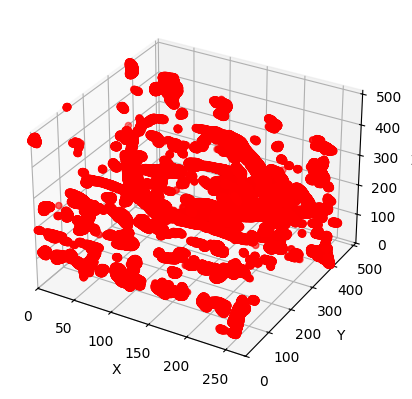

In [29]:
from data_generation.generate_3d import visualize3Dimage

visualize3Dimage(prediction)

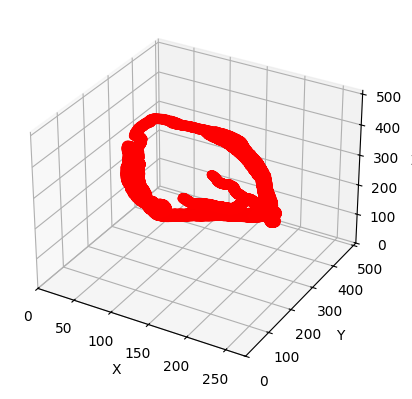

In [30]:
visualize3Dimage(test_ccta_mask)

In [31]:
# loss = dice_bce_loss(prediction, test_ccta_mask).item()
jaccard = calculate_jaccard_score(prediction, test_ccta_mask)
print(jaccard)

dice = calculate_dice_score(prediction, test_ccta_mask)
print(dice)

0.2236364829683432
0.36552764825356865


In [ ]:
amt_of_test_patients = 10

average_jaccard = 0
average_dice = 0

for patient_idx in range(amt_of_test_patients):
    print(f"processing patient {patient_idx + 1} / {amt_of_test_patients}")
    test_ccta_scan, test_ccta_mask = test_patients[patient_idx].get_image_mask_tuple()

    prediction = ccta_pipeline(test_ccta_scan)
    jaccard = calculate_jaccard_score(prediction, test_ccta_mask)
    average_jaccard += jaccard
    print(f"jaccard score: {jaccard}")

    dice = calculate_dice_score(prediction, test_ccta_mask)
    average_dice += dice
    print(f"dice score: {dice}")

average_jaccard /= amt_of_test_patients
average_dice /= amt_of_test_patients

print(f"average jaccard: {average_jaccard}")
print(f"average dice: {average_dice}")

processing patient 1 / 10
(320, 512, 512)
jaccard score: 0.2236364829683432
dice score: 0.36552764825356865
processing patient 2 / 10
(256, 512, 512)
jaccard score: 0.05928017241751346
dice score: 0.11192538850646641
processing patient 3 / 10
(256, 512, 512)
jaccard score: 0.10205290678206218
dice score: 0.18520509524366016
processing patient 4 / 10
(320, 512, 512)
jaccard score: 0.0518144965454923
dice score: 0.09852402056763486
processing patient 5 / 10
(256, 512, 512)
jaccard score: 0.08390351504258492
dice score: 0.15481731330908816
processing patient 6 / 10


In [11]:
block_shape = (block_size,block_size,block_size)
pred_z_max = prediction.shape[0]
pred_z_max = pred_z_max - (pred_z_max % block_size)
prediction_patches = divide_3d_image_into_patches(prediction[0:pred_z_max,:,:], block_shape=block_shape)

In [12]:
prediction_patches.shape

(2, 4, 4, 128, 128, 128)

In [43]:
smaller_mask = test_ccta_mask[0:pred_z_max]
smaller_pred = prediction[0:pred_z_max]

In [44]:
prediction_patches = divide_3d_image_into_patches(smaller_pred, block_shape=block_shape)
mask_patches = divide_3d_image_into_patches(smaller_mask, block_shape=block_shape)

In [45]:
patches_amt = prediction_patches.shape[0] * prediction_patches.shape[1] * prediction_patches.shape[2]
print(f"amt of prediction patches: {patches_amt}")

amt of prediction patches: 32


In [ ]:
test_ccta_scan, test_ccta_mask = test_patients[0].get_image_mask_tuple()

prediction = ccta_pipeline(test_ccta_scan)

block_shape = (block_size,block_size,block_size)
pred_z_max = prediction.shape[0]
pred_z_max = pred_z_max - (pred_z_max % block_size)
prediction_patches = divide_3d_image_into_patches(prediction[0:pred_z_max,:,:], block_shape=block_shape)

smaller_mask = test_ccta_mask[0:pred_z_max]
smaller_pred = prediction[0:pred_z_max]

prediction_patches = divide_3d_image_into_patches(smaller_pred, block_shape=block_shape)
mask_patches = divide_3d_image_into_patches(smaller_mask, block_shape=block_shape)

patch_counter = 0
patch_shape = prediction_patches.shape
for i in range(patch_shape[0]):
    for j in range(patch_shape[1]):
        for k in range(patch_shape[2]):
            patch_counter += 1
            current_mask_patch = mask_patches[i,j,k]
            
            print(current_mask_patch)
            print(current_mask_patch.shape)
            if np.all(current_mask_patch == 0):
                    print("skipping patch")
                    continue
            
            current_pred_patch = prediction_patches[i,j,k]
            visualize3Dimage(current_mask_patch)
            visualize3Dimage(current_pred_patch)
            break

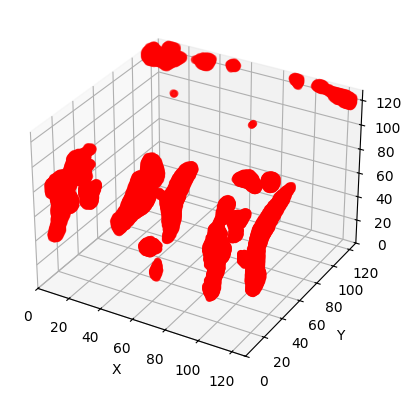

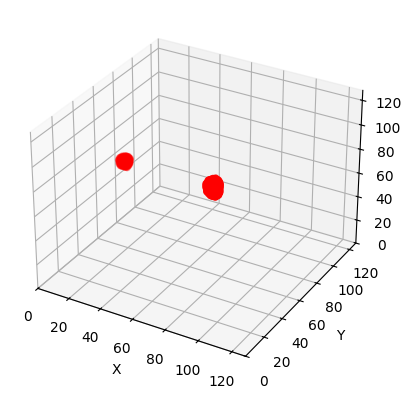

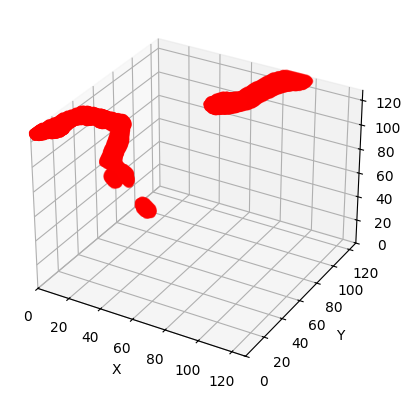

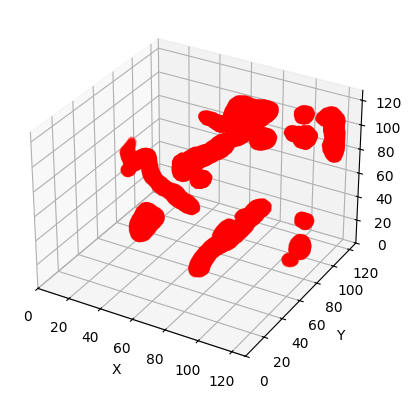

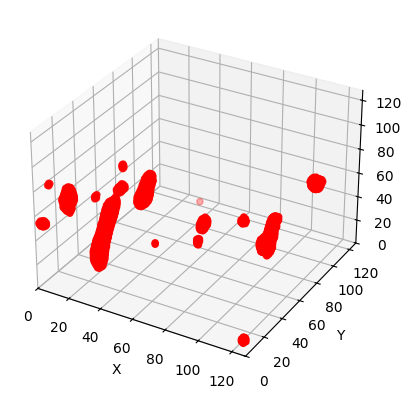

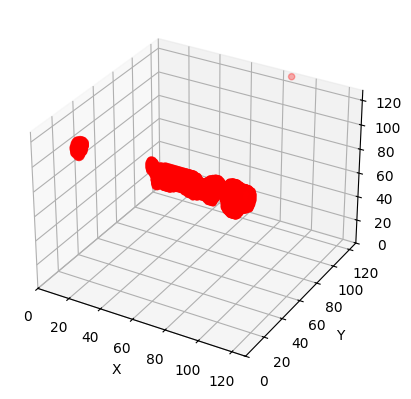

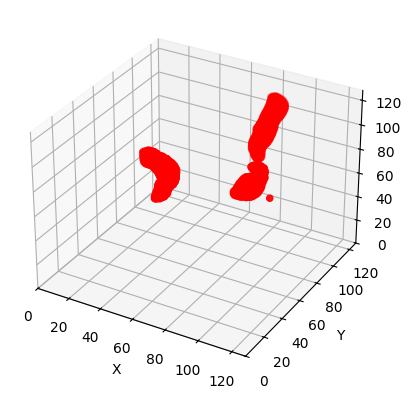

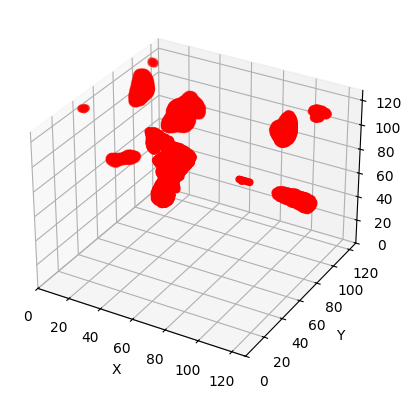

In [47]:
patch_counter = 0
patch_shape = prediction_patches.shape
for i in range(patch_shape[0]):
    for j in range(patch_shape[1]):
        for k in range(patch_shape[2]):
            patch_counter += 1
            current_mask_patch = mask_patches[i,j,k]
            
            
            if np.all(current_mask_patch == 1):
                    print("skipping patch")
                    continue
            
            current_pred_patch = prediction_patches[i,j,k]
            # visualize3Dimage(current_mask_patch)
            visualize3Dimage(current_pred_patch)
            break